# WiDS Kalman Filtered Trend Trader — Assignment 1  



In [1]:
# imports (basic)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from scipy import stats

%matplotlib inline


## Question 1 — Linear Regression (theory)

### 1) Multiple linear regression model (p predictors)

```python
# y = Xβ + ε
# y: (n x 1) response
# X: (n x (p+1)) design matrix (first col ones)
# β: (p+1 x 1) coeffs [β0..βp]
# ε: noise
#
# assumptions (usual)
# linear in params
# E[ε | X] = 0
# Var(ε | X) = σ^2 I
# errors approx normal (mainly for inference)
```


### 2) What OLS minimizes + full MSE objective

```python
# residual r = y - Xβ
# SSE = ||y - Xβ||^2
# MSE objective: J(β) = (1/n) ||y - Xβ||^2
# sometimes J(β) = (1/2n) ||Xβ - y||^2 (nice gradient)
```


### 3) Derive β_hat

```python
# J(β) = (1/2n)||Xβ - y||^2
# ∇β J = (1/n) X^T (Xβ - y)
# set to 0:
# X^T X β = X^T y
# if invertible:
# β_hat = (X^T X)^(-1) X^T y
```


### 4) When X^T X invertible + multicollinearity issue

```python
# invertible when columns of X are linearly independant (full rank)
# multicollinearity -> some column = combo of others
# => rank drops
# => X^T X singular
```


### 5) Projection + prove X^T(y - y_hat)=0

```python
# y_hat = Xβ_hat
# e = y - y_hat
# normal eqns: X^T (y - Xβ_hat) = 0
# so X^T e = 0
# residual orthogonal to Col(X)
# => y_hat is orth proj of y onto Col(X)
```


### 6) Gradient + batch GD

```python
# J(β) = (1/2n)||Xβ - y||^2
# ∇β J = (1/n) X^T (Xβ - y)
# update: β <- β - η * (1/n) X^T (Xβ - y)
```


### 7) Compute β_hat with NumPy, compare with sklearn

In [2]:
import os


cands = [
    "/content/linear_regression_dataset (1).csv",
]
path = None
for p in cands:
    if os.path.exists(p):
        path = p
        break

print("using:", path)
df = pd.read_csv(path)
df.head()


using: /content/linear_regression_dataset (1).csv


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,y
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560,-0.463418,-0.465730,-0.509170
1,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,1.465649,-0.225776,0.067528,-1.424748,6.445471
2,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,-3.270552
3,0.208864,-1.959670,-1.328186,0.196861,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,1.964911
4,0.343618,-1.763040,0.324084,-0.385082,-0.676922,0.611676,1.031000,0.931280,-0.839218,-0.309212,0.331263,0.975545,2.058044


In [3]:
# X, y + intercept
y = df["y"].values.reshape(-1,1)
X = df[[f"x{i}" for i in range(1,13)]].values
X1 = np.hstack([np.ones((X.shape[0],1)), X])

beta_hat = np.linalg.inv(X1.T @ X1) @ (X1.T @ y)
beta_hat[:6].ravel()


array([-0.07599727,  3.01921283, -1.9986479 ,  0.46532073,  0.02874601,
        0.97888014])

In [4]:
lr = LinearRegression(fit_intercept=True)
lr.fit(X, y)

beta_sklearn = np.vstack([lr.intercept_.reshape(1,1), lr.coef_.reshape(-1,1)])
print("max abs diff:", float(np.max(np.abs(beta_hat - beta_sklearn))))


max abs diff: 1.4918621893400541e-15


### 8) Residuals vs fitted (homoscedasticity)

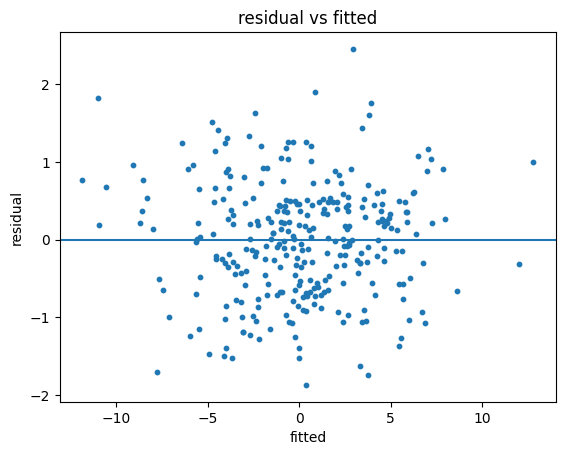

In [5]:
yhat = (X1 @ beta_hat).ravel()
res  = (y.ravel() - yhat)

plt.figure()
plt.scatter(yhat, res, s=10)
plt.axhline(0)
plt.xlabel("fitted")
plt.ylabel("residual")
plt.title("residual vs fitted")
plt.show()

# comment
# flat cloud -> ok-ish
# funnel -> heteroscedastic maybe


### 9) Q–Q plot (normality)

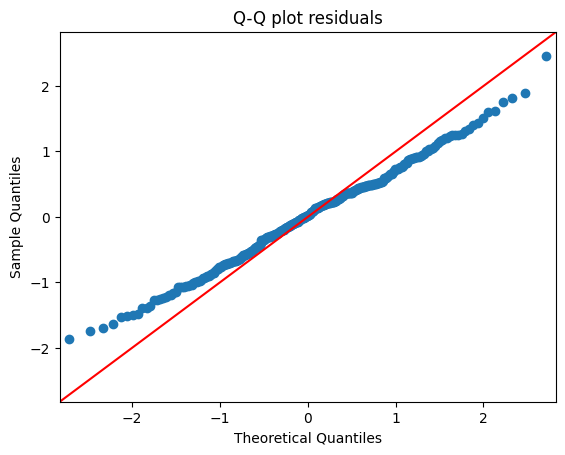

In [6]:
sm.qqplot(res, line="45")
plt.title("Q-Q plot residuals")
plt.show()

# comment
# on line -> kinda normal
# tail bend -> heavy tails


### 10) What violations indicate

```python
# heteroscedastic -> wrong constant variance, inference off
# non-normal -> pvals/CI shaky (esp small n)
# curved residual pattern -> missing nonlinearity
# outliers -> coeffs get pulled
```


### 11) Hat matrix, leverage, Cook's distance

lev thr: 0.08666666666666667 | high lev count: 3
cook thr: 0.013333333333333334 | infl count: 14


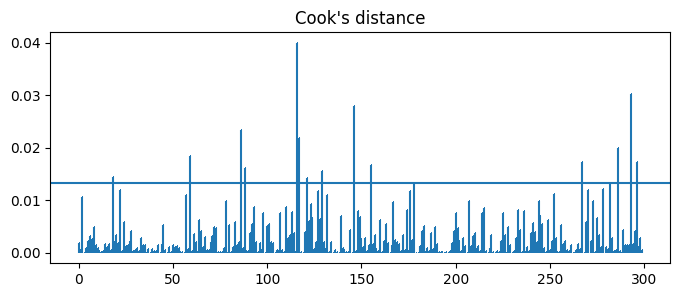

beta change L2: 0.09189861879747821


In [7]:
H = X1 @ np.linalg.inv(X1.T @ X1) @ X1.T
h = np.diag(H)

n = X1.shape[0]
p = X1.shape[1] - 1
lev_thr = 2*(p+1)/n

hi_idx = np.where(h > lev_thr)[0]
print("lev thr:", lev_thr, "| high lev count:", len(hi_idx))

# Cook D
MSE = np.sum(res**2) / (n - (p+1))
D = (res**2 / ((p+1)*MSE)) * (h / (1-h)**2)
cook_thr = 4/n
infl_idx = np.where(D > cook_thr)[0]
print("cook thr:", cook_thr, "| infl count:", len(infl_idx))

plt.figure(figsize=(8,3))
plt.stem(D, markerfmt=",", basefmt=" ")
plt.axhline(cook_thr)
plt.title("Cook's distance")
plt.show()

# impact check (refit w/o infl)
if len(infl_idx) > 0:
    mask = np.ones(n, dtype=bool)
    mask[infl_idx] = False
    Xb = X1[mask]
    yb = y[mask]
    bb = np.linalg.inv(Xb.T @ Xb) @ (Xb.T @ yb)
    print("beta change L2:", float(np.linalg.norm(beta_hat - bb)))


### 12) Bias–Variance decomposition

```python
# y = f(x) + ε, E[ε]=0, Var(ε)=σ^2
# MSE = E[(y - f_hat(x))^2]
# = Bias^2 + Var + σ^2
```


### 13) Omitted variable bias (OVB)

```python
# true: y = β0 + β1 x1 + β2 x2 + ε
# fit:  y = α0 + α1 x1 + u
#
# E[α1] = β1 + β2 * Cov(x1,x2)/Var(x1)
# bias = β2 * Cov(x1,x2)/Var(x1)
# no bias if β2=0 OR Cov(x1,x2)=0
```


### 14) Multicollinearity sim + condition number

In [8]:
np.random.seed(0)

n_sim = 500
x1 = np.random.randn(n_sim)
z  = np.random.randn(n_sim)
x2 = x1 + 0.9*z

Xsim = np.column_stack([np.ones(n_sim), x1, x2])
cond = np.linalg.cond(Xsim.T @ Xsim)
print("cond number:", cond)

# show variance grows when corr grows (smaller scale on z)
def beta_var(scale, reps=120):
    betas = []
    for _ in range(reps):
        x1 = np.random.randn(n_sim)
        z  = np.random.randn(n_sim)
        x2 = x1 + scale*z
        eps = 0.5*np.random.randn(n_sim)
        yv = 2 + 1.5*x1 - 1.0*x2 + eps
        X = np.column_stack([np.ones(n_sim), x1, x2])
        b = np.linalg.inv(X.T@X) @ (X.T @ yv.reshape(-1,1))
        betas.append(b.ravel())
    betas = np.array(betas)
    return betas.var(axis=0)

for s in [2.0, 1.0, 0.5, 0.2]:
    v = beta_var(s)
    print("scale", s, "var(beta0,beta1,beta2) =", v)

# note
# multicollinearity -> variance up, coeffs unstable
# but no bias if E[ε|X]=0


cond number: 7.361386937215215
scale 2.0 var(beta0,beta1,beta2) = [0.00051277 0.00069259 0.00010797]
scale 1.0 var(beta0,beta1,beta2) = [0.00043216 0.00129642 0.00058248]
scale 0.5 var(beta0,beta1,beta2) = [0.00050417 0.00266865 0.00196334]
scale 0.2 var(beta0,beta1,beta2) = [0.00063814 0.00938284 0.00936296]


# Question 2 — Salary Prediction & Bias Detection

Expected file: `salary dataset.csv` in `/mnt/data`.  
If missing, we make a toy dataset (fake) just to demo workflow.


In [12]:
import os

salary_path = None
for p in ["/content/salary_dataset.csv"]:
    if os.path.exists(p):
        salary_path = p
        break
salary_df = pd.read_csv(salary_path)

salary_df.head()


,age,gender,education_level,years_experience,job_title,performance_score,industry,city,previous_companies,remote_worker,salary
0,30,Male,Bachelors,5.9,JobRole_5,3.0,Tech,Dallas,5,Yes,93292.58
1,37,Female,PhD,17.9,JobRole_13,5.0,Tech,Austin,1,Yes,138714.55
2,42,Female,Bachelors,19.1,JobRole_14,4.4,Finance,Austin,2,No,93073.72
3,30,Female,Bachelors,7.7,JobRole_15,3.8,Finance,Denver,1,No,83050.31
4,42,Male,Bachelors,23.2,JobRole_13,4.1,Tech,New York,3,No,160544.79


## 1) EDA

In [13]:
salary_df.describe(include="all").T.head(20)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,12000.0,NaN,NaN,NaN,35.693083,7.741977,21.0,30.0,36.0,41.0,65.0
gender,12000,3,Male,6691,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_level,11885,4,Bachelors,6603,NaN,NaN,NaN,NaN,NaN,NaN,NaN
years_experience,11868.0,NaN,NaN,NaN,15.73153,8.204885,0.0,9.9,15.55,21.3,45.0
job_title,12000,15,JobRole_10,837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
performance_score,11746.0,NaN,NaN,NaN,3.752103,0.775138,1.0,3.2,3.8,4.3,5.0
industry,12000,4,Tech,5367,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,11940,12,Miami,1032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous_companies,12000.0,NaN,NaN,NaN,1.984417,1.397797,0.0,1.0,2.0,3.0,12.0
remote_worker,12000,2,No,6850,NaN,NaN,NaN,NaN,NaN,NaN,NaN


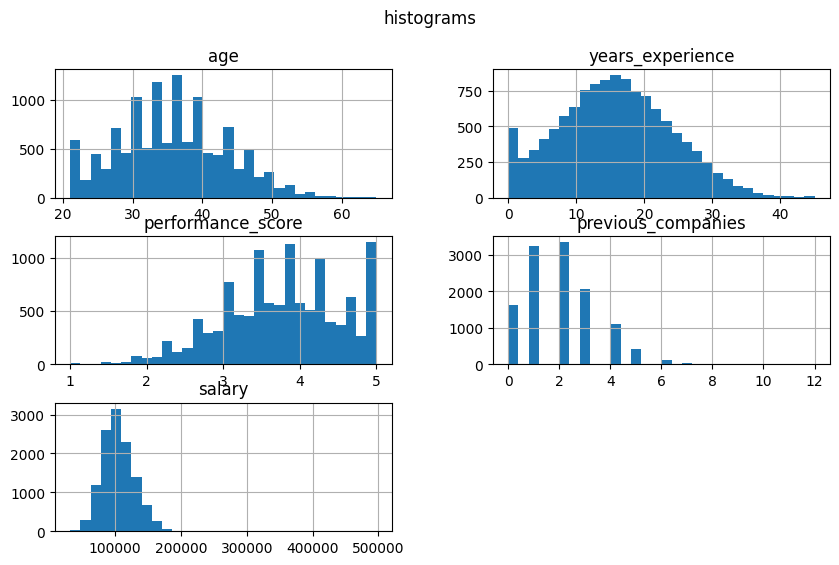

In [15]:
cols_num = ["age","years_experience","performance_score","previous_companies","salary"]
salary_df[cols_num].hist(bins=30, figsize=(10,6))
plt.suptitle("histograms")
plt.show()

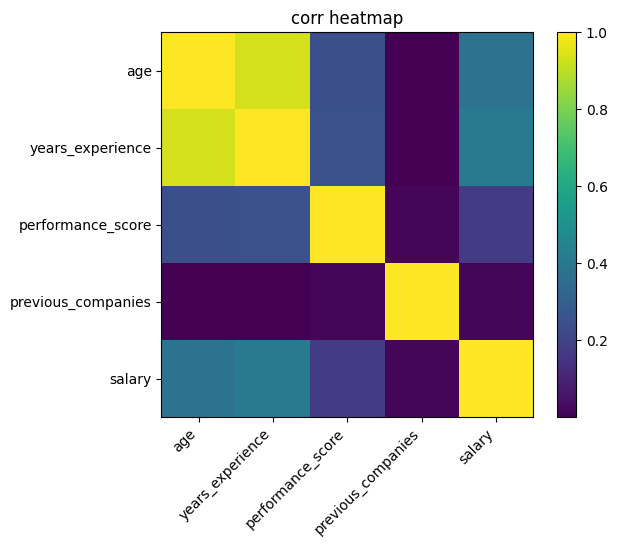

In [16]:
corr = salary_df[cols_num].corr(numeric_only=True)
plt.figure(figsize=(6,5))
plt.imshow(corr, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("corr heatmap")
plt.show()


/tmp/ipython-input-3726882826.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


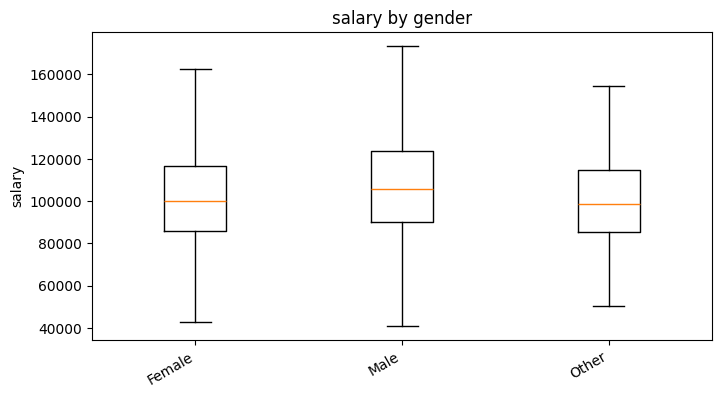

/tmp/ipython-input-3726882826.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


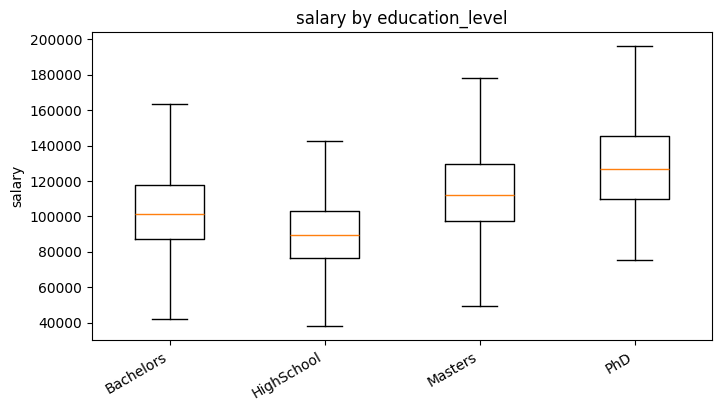

/tmp/ipython-input-3726882826.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


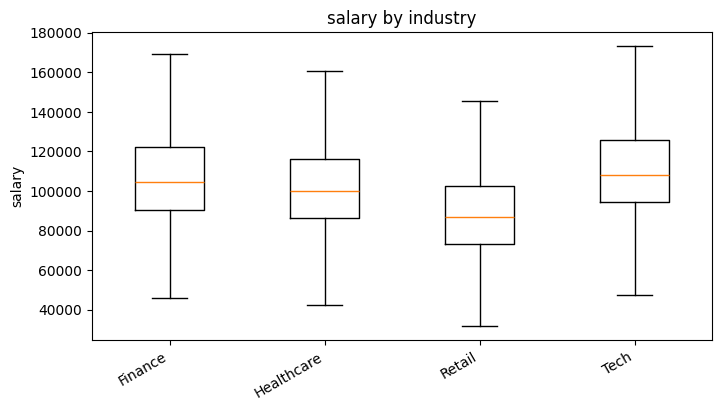

In [18]:
def box_by(col):
    groups = salary_df.groupby(col)["salary"].apply(list)
    labels = list(groups.index)
    data = [groups[k] for k in labels]
    plt.figure(figsize=(8,4))
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.title("salary by " + col)
    plt.xticks(rotation=30, ha="right")
    plt.ylabel("salary")
    plt.show()

box_by("gender")
box_by("education_level")
box_by("industry")

## 2) Missing + outliers

In [19]:
df2 = salary_df.copy()

# missing
print(df2.isna().sum())

# fill simple
for c in df2.columns:
    if df2[c].dtype == "object":
        if df2[c].isna().any():
            df2[c] = df2[c].fillna(df2[c].mode().iloc[0])
    else:
        if df2[c].isna().any():
            df2[c] = df2[c].fillna(df2[c].median())

# clip salary outliers
lo, hi = df2["salary"].quantile([0.01, 0.99])
df2["salary"] = df2["salary"].clip(lo, hi)

(lo, hi)


age                     0
gender                  0
education_level       115
years_experience      132
job_title               0
performance_score     254
industry                0
city                   60
previous_companies      0
remote_worker           0
salary                  0
dtype: int64


(56635.3244, 171449.96600000001)

## 3) Encoding choice

```python
# one-hot encoding
# simple + works with linear regression
# keeps interpretability
```


In [20]:
target = "salary"
X = df2.drop(columns=[target])
y = df2[target].values

X_enc = pd.get_dummies(X, drop_first=True)
X_enc.shape


(12000, 38)

## 4) Stratified split (salary bins)

```python
# salary continuous
# make quantile bins
# stratify on bins so train/test salary distrib similar
```


In [21]:
bins = pd.qcut(df2["salary"], q=10, labels=False, duplicates="drop")

X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, random_state=42, stratify=bins
)
X_train.shape, X_test.shape


((9600, 38), (2400, 38))

## 5) Baseline OLS model

In [22]:
lr2 = LinearRegression()
lr2.fit(X_train, y_train)
pred = lr2.predict(X_test)


## 6) Coefs + std err + pvals + CI (statsmodels)

In [26]:
X_train_numeric = X_train.apply(pd.to_numeric, errors='coerce').fillna(0) # Convert all columns to numeric, coerce errors to NaN, then fill NaNs with 0
X_train_sm = sm.add_constant(X_train_numeric, has_constant="add")

# Explicitly convert the DataFrame to a NumPy array with a numeric dtype
# This ensures statsmodels definitely receives numeric data
X_train_sm_array = X_train_sm.values.astype(float)

ols = sm.OLS(y_train, X_train_sm_array).fit()

# coef table (top rows)
ols.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,5.077e+04,1002.224,50.653,0.000,4.88e+04,5.27e+04
x1,114.5667,32.455,3.530,0.000,50.948,178.185
x2,1169.4577,30.856,37.900,0.000,1108.973,1229.943
x3,2811.5976,126.572,22.213,0.000,2563.490,3059.706
x4,249.6002,67.259,3.711,0.000,117.759,381.442
x5,5343.4251,190.499,28.050,0.000,4970.006,5716.844
x6,-2626.7641,732.524,-3.586,0.000,-4062.666,-1190.863
x7,-1.283e+04,273.859,-46.855,0.000,-1.34e+04,-1.23e+04
x8,1.047e+04,227.146,46.103,0.000,1e+04,1.09e+04
x9,2.446e+04,445.976,54.855,0.000,2.36e+04,2.53e+04


In [29]:
ci = pd.DataFrame(ols.conf_int(alpha=0.05), columns=["ci_low","ci_high"])
coef_table = pd.DataFrame({
    "coef": ols.params,
    "std_err": ols.bse,
    "pval": ols.pvalues
}).join(ci)

coef_table.sort_values("coef", key=lambda s: np.abs(s), ascending=False).head(12)

,coef,std_err,pval,ci_low,ci_high
0,50765.203571,1002.224189,0.000000e+00,48800.631553,52729.775589
36,42264.883386,459.477952,0.000000e+00,41364.209129,43165.557643
34,37931.950179,466.226465,0.000000e+00,37018.047405,38845.852953
9,24464.136497,445.975628,0.000000e+00,23589.929659,25338.343335
32,24154.419659,457.625009,0.000000e+00,23257.377563,25051.461755
37,23809.044367,462.396211,0.000000e+00,22902.649703,24715.439032
28,21645.550329,457.760320,0.000000e+00,20748.242995,22542.857664
25,-17540.037093,320.251635,0.000000e+00,-18167.798234,-16912.275952
7,-12831.520259,273.858522,0.000000e+00,-13368.341058,-12294.699460
11,12016.726162,525.509915,1.012515e-112,10986.615249,13046.837075


## 7) Interpret 5 most influential coefs

In [30]:
tmp = coef_table.drop(index="const", errors="ignore").copy()
top5 = tmp.reindex(tmp["coef"].abs().sort_values(ascending=False).head(5).index)
top5


,coef,std_err,pval,ci_low,ci_high
0,50765.203571,1002.224189,0.0,48800.631553,52729.775589
36,42264.883386,459.477952,0.0,41364.209129,43165.557643
34,37931.950179,466.226465,0.0,37018.047405,38845.852953
9,24464.136497,445.975628,0.0,23589.929659,25338.343335
32,24154.419659,457.625009,0.0,23257.377563,25051.461755


In [31]:
for name, row in top5.iterrows():
    print("-", name,
          "| coef", round(row["coef"],2),
          "| up" if row["coef"]>0 else "| down",
          "| idea: +1 in feature -> salary shift by coef, holding others fixed")


- 0 | coef 50765.2 | up | idea: +1 in feature -> salary shift by coef, holding others fixed
- 36 | coef 42264.88 | up | idea: +1 in feature -> salary shift by coef, holding others fixed
- 34 | coef 37931.95 | up | idea: +1 in feature -> salary shift by coef, holding others fixed
- 9 | coef 24464.14 | up | idea: +1 in feature -> salary shift by coef, holding others fixed
- 32 | coef 24154.42 | up | idea: +1 in feature -> salary shift by coef, holding others fixed


## 8) RMSE, MAE, R2

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Removed 'squared=False' and compute RMSE by taking the square root of MSE
rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)

rmse, mae, r2

(np.float64(8892.86337201483), 6699.455457741886, 0.8636979903977304)

## 9) Assumption checks

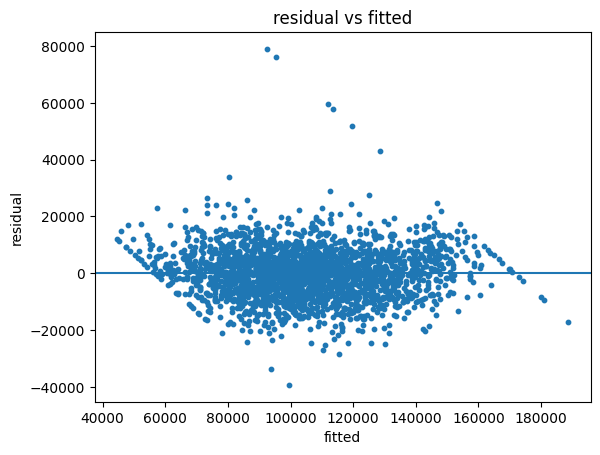

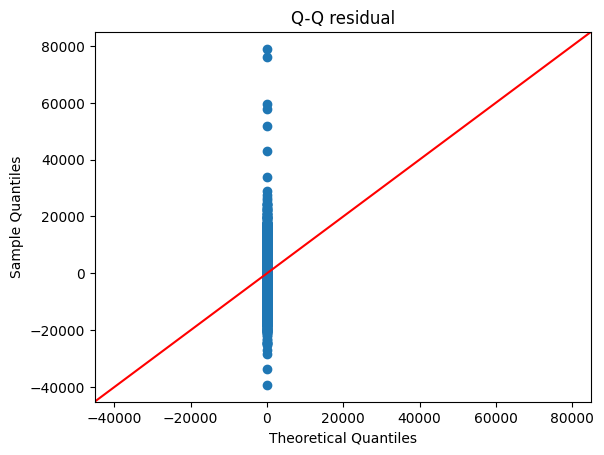

In [34]:
res2 = y_test - pred

plt.figure()
plt.scatter(pred, res2, s=10)
plt.axhline(0)
plt.xlabel("fitted")
plt.ylabel("residual")
plt.title("residual vs fitted")
plt.show()

sm.qqplot(res2, line="45")
plt.title("Q-Q residual")
plt.show()

# phrases
# curve -> nonlinearity maybe
# fan -> heteroscedastic maybe


## 10) Fairness metrics (gender protected)

Need binary outcome for some metrics.  
We set **HighSalary = salary >= 75th percentile (true salary on test)**.


In [35]:
test_df = df2.loc[X_test.index].copy()
test_df["y_true"] = y_test
test_df["y_pred"] = pred
test_df["resid"]  = test_df["y_true"] - test_df["y_pred"]

thr = np.quantile(test_df["y_true"], 0.75)
test_df["high_true"] = (test_df["y_true"] >= thr).astype(int)
test_df["high_pred"] = (test_df["y_pred"] >= thr).astype(int)

thr


np.float64(120514.8125)

In [36]:
def mae_group(df, g):
    d = df[df["gender"]==g]
    return float(np.mean(np.abs(d["y_true"] - d["y_pred"])))

def sel_rate(df, g):
    d = df[df["gender"]==g]
    return float(d["high_pred"].mean())

def tpr(df, g):
    d = df[df["gender"]==g]
    tp = np.sum((d["high_true"]==1) & (d["high_pred"]==1))
    fn = np.sum((d["high_true"]==1) & (d["high_pred"]==0))
    return float(tp / (tp+fn + 1e-9))

def fpr(df, g):
    d = df[df["gender"]==g]
    fp = np.sum((d["high_true"]==0) & (d["high_pred"]==1))
    tn = np.sum((d["high_true"]==0) & (d["high_pred"]==0))
    return float(fp / (fp+tn + 1e-9))

def fairness(df, ref, other):
    out = {}
    out["Mean Salary Prediction Difference"] = float(df[df["gender"]==ref]["y_pred"].mean() - df[df["gender"]==other]["y_pred"].mean())
    out["Mean Abs Error ref"] = mae_group(df, ref)
    out["Mean Abs Error other"] = mae_group(df, other)
    out["DPD (sel rate diff)"] = sel_rate(df, ref) - sel_rate(df, other)
    out["EOD (TPR diff)"] = tpr(df, ref) - tpr(df, other)
    out["Predictive Equality (FPR diff)"] = fpr(df, ref) - fpr(df, other)
    out["DIR (sel rate ratio)"] = sel_rate(df, other) / (sel_rate(df, ref) + 1e-9)
    return out

rep_m_f = fairness(test_df, "Male", "Female")
rep_m_o = fairness(test_df, "Male", "Other")

pd.DataFrame([rep_m_f, rep_m_o], index=["Male vs Female","Male vs Other"]).T


,Male vs Female,Male vs Other
Mean Salary Prediction Difference,6105.420535,8261.932363
Mean Abs Error ref,6739.016398,6739.016398
Mean Abs Error other,6686.486241,5931.403747
DPD (sel rate diff),0.071026,0.069805
EOD (TPR diff),0.054545,-0.045933
Predictive Equality (FPR diff),-0.002776,0.026651
DIR (sel rate ratio),0.747547,0.751887


In [49]:
# quick meaning
# Mean pred diff -> avg predicted salary gap
# MAE per group -> accuracy gap
# DPD -> high-salary selection gap
# EOD -> TPR gap on true high-salary people
# Pred equality -> FPR gap on true low-salary people
# DIR -> selection ratio (below ~0.8 can be red flag)


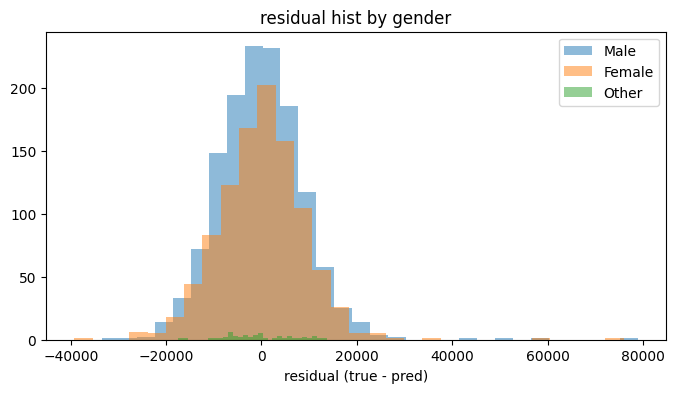

In [38]:
# residual distrib by gender
plt.figure(figsize=(8,4))
for g in ["Male","Female","Other"]:
    d = test_df[test_df["gender"]==g]["resid"].values
    if len(d) == 0:
        continue
    plt.hist(d, bins=30, alpha=0.5, label=g)
plt.legend()
plt.title("residual hist by gender")
plt.xlabel("residual (true - pred)")
plt.show()


## 11) t-test on mean residuals (Male vs Female etc)

In [39]:
male_res = test_df[test_df["gender"]=="Male"]["resid"].values
fem_res  = test_df[test_df["gender"]=="Female"]["resid"].values
tstat, pval = stats.ttest_ind(male_res, fem_res, equal_var=False)
tstat, pval


(np.float64(-0.20647292341249768), np.float64(0.8364409732577567))

In [40]:
oth_res = test_df[test_df["gender"]=="Other"]["resid"].values
if len(oth_res) >= 5:
    t2, p2 = stats.ttest_ind(male_res, oth_res, equal_var=False)
    print("Male vs Other t,p:", t2, p2)
else:
    print("Other group too small here")


Male vs Other t,p: 0.4605360869568412 0.6468781710706168


## 12) Over / under estimate by group

In [41]:
# mean resid > 0 -> underpredicting
# mean resid < 0 -> overpredicting
test_df.groupby("gender")["resid"].mean()


,resid
gender,
Female,10.106204
Male,-66.860191
Other,-541.523531


## 13) SHAP (try, else fallback)

In [42]:
try:
    import shap
    shap.initjs()
    use_shap = True
except Exception as e:
    print("shap not available:", e)
    use_shap = False

use_shap


True

/tmp/ipython-input-1218822143.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv, Xs_sampled_df, show=False)


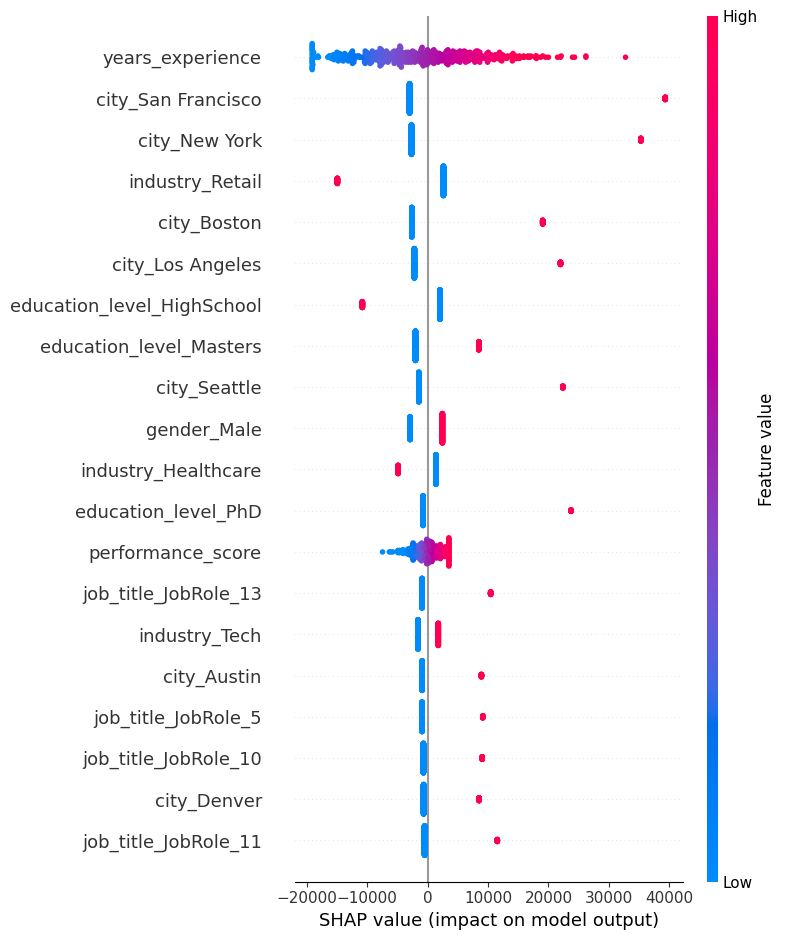

top 3 feats: ['years_experience', 'city_San Francisco', 'city_New York']


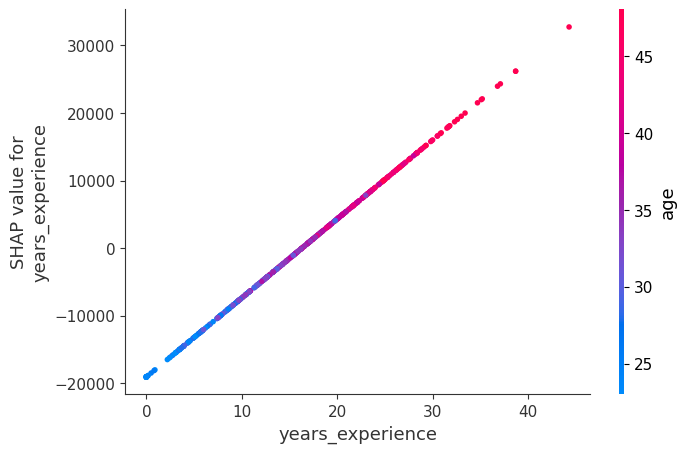

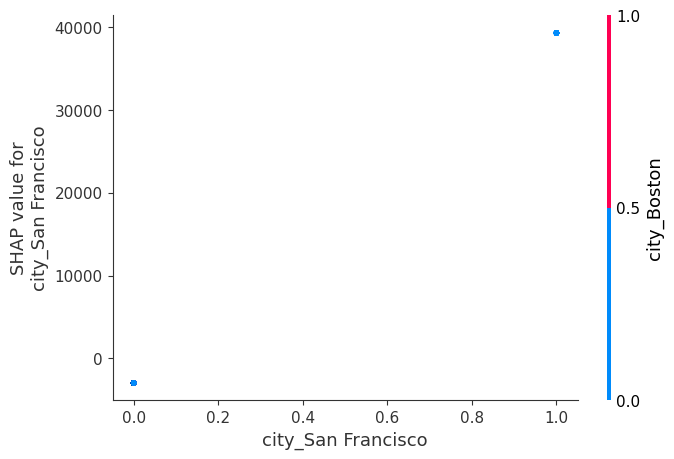

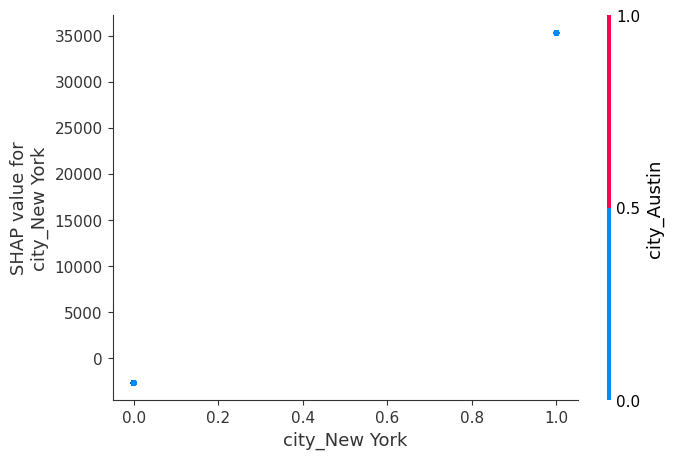

In [44]:
if use_shap:
    # Ensure the sampled data for SHAP is explicitly a numpy array of floats
    Xs_sampled_df = X_train.sample(min(500, len(X_train)), random_state=0)
    Xs_array_for_explainer = Xs_sampled_df.values.astype(float)

    # Initialize the explainer with the numpy array
    expl = shap.LinearExplainer(lr2, Xs_array_for_explainer)
    sv = expl.shap_values(Xs_array_for_explainer) # Get shap values using the array

    # For summary_plot, pass the original DataFrame to retain column names for better visualization
    shap.summary_plot(sv, Xs_sampled_df, show=False)
    plt.show()

    mabs = np.mean(np.abs(sv), axis=0)
    top_idx = np.argsort(mabs)[-3:][::-1]
    top_feats = Xs_sampled_df.columns[top_idx] # Use the DataFrame for column names
    print("top 3 feats:", list(top_feats))

    for f in top_feats:
        # For dependence_plot, pass the original DataFrame to retain context for plotting
        shap.dependence_plot(f, sv, Xs_sampled_df, show=False)
        plt.show()
else:
    coef_abs = pd.Series(lr2.coef_, index=X_train.columns).abs().sort_values(ascending=False).head(10)
    coef_abs

# Question 3 — Deep Neural Network Classifier for Digits (PyTorch)

Assume `train_loader` and `val_loader` exist.  
If not, we make random loaders (toy), just so code runs.


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


## DigitClassifier class


In [46]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # logits
        return x


## Train loop (5 epochs)


In [47]:
def make_dummy_loaders(n_train=2000, n_val=400):
    Xtr = torch.randn(n_train, 784)
    ytr = torch.randint(0, 10, (n_train,))
    Xva = torch.randn(n_val, 784)
    yva = torch.randint(0, 10, (n_val,))
    tr = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
    va = DataLoader(TensorDataset(Xva, yva), batch_size=64, shuffle=False)
    return tr, va

if "train_loader" not in globals() or "val_loader" not in globals():
    train_loader, val_loader = make_dummy_loaders()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [48]:
model = DigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()

        total_loss += float(loss.item()) * xb.size(0)
        preds = torch.argmax(out, dim=1)
        correct += int((preds == yb).sum().item())
        total += xb.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    model.eval()
    v_loss = 0.0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            v_loss += float(loss.item()) * xb.size(0)
            preds = torch.argmax(out, dim=1)
            v_correct += int((preds == yb).sum().item())
            v_total += xb.size(0)

    val_loss = v_loss / v_total
    val_acc = v_correct / v_total

    print("epoch", epoch+1, "| train loss", round(train_loss,4), "acc", round(train_acc,4),
          "| val loss", round(val_loss,4), "acc", round(val_acc,4))


epoch 1 | train loss 2.3076 acc 0.0995 | val loss 2.3027 acc 0.125
epoch 2 | train loss 1.9841 acc 0.564 | val loss 2.352 acc 0.1175
epoch 3 | train loss 1.2071 acc 0.7485 | val loss 2.8427 acc 0.1025
epoch 4 | train loss 0.3265 acc 0.951 | val loss 3.562 acc 0.0875
epoch 5 | train loss 0.0593 acc 0.9995 | val loss 3.9908 acc 0.095


## Theory Qs

### 1) Why ReLU preferred (2 reasons)

```python
# less vanishing gradient (sigmoid/tanh saturate)
# fast + simple
```

### 2) autograd role

```python
# tracks forward ops
# makes compute graph
# backward pass computes grads
# optimizer uses grads to update params
```
